In [222]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import numpy as np

In [29]:
!pip install geocoder

In [31]:
import geocoder

In [34]:
!pip install folium
import folium

In [8]:
location_uri = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore'

In [26]:
# URL of wikipedia page from which to scrap tabular data.
location_uri

# If the request was successful, reponse should be '200'.
response = requests.get(location_uri)

# Parse response content to html with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the right table in the HTML sourcecode
wiki_table=soup.find('table', {"class":'wikitable sortable'})

# Placeholder for list of neighbourhoods
bangalore_neighbourhoods = []

# Iterate through the rows of the table
# Note: each district has sub-rows of neighbourhoods
for row in wiki_table.findAll("tr"):    
    cells = row.findAll('td')

    # Parse 1st neighbourhood of the district
    if len(cells)==3:
        bangalore_neighbourhoods.append(cells[0].find(text=True).replace('\n', '').rstrip().lstrip().upper())
    
    # Parse sub-rows (rest of neighbourhoods of the district)
    elif len(cells)==3:
        bangalore_neighbourhoods.append(cells[1].find(text=True).replace('\n', '').rstrip().lstrip().upper())

# Display neighbourhood dataframe
df_bangalore = pd.DataFrame(bangalore_neighbourhoods, columns=['Neighbourhood'])
print(f'Shape: {df_bangalore.shape}')
df_bangalore.head()

Shape: (11, 1)


,Neighbourhood
0,CANTONMENT
1,DOMLUR
2,INDIRANAGAR
3,RAJAJINAGAR
4,MALLESWARAM


In [27]:
df_bangalore

,Neighbourhood
0,CANTONMENT
1,DOMLUR
2,INDIRANAGAR
3,RAJAJINAGAR
4,MALLESWARAM
5,PETE
6,SADASHIVANAGAR
7,SESHADRIPURAM
8,SHIVAJINAGAR
9,ULSOOR


In [32]:
# Function that retrieves the geographical coordinates for a given neighborhood
def get_coordinates(row):
    # initialize variable to None
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis(f'{row["Neighbourhood"]}, Bangalore')
      lat_lng_coords = g.latlng
    
    # return pair lat,long
    return pd.Series([lat_lng_coords[0], lat_lng_coords[1]])
    
# Fill coordinates for each row
df_bangalore[['Latitude','Longitude']] = df_bangalore.apply(get_coordinates, axis=1)
df_bangalore.head()
    

,Neighbourhood,Latitude,Longitude
0,CANTONMENT,30.60849,-87.32712
1,DOMLUR,12.94329,77.65602
2,INDIRANAGAR,13.03006,77.49526
3,RAJAJINAGAR,13.00544,77.55693
4,MALLESWARAM,13.00632,77.56840


In [33]:
df_bangalore

,Neighbourhood,Latitude,Longitude
0,CANTONMENT,30.60849,-87.32712
1,DOMLUR,12.94329,77.65602
2,INDIRANAGAR,13.03006,77.49526
3,RAJAJINAGAR,13.00544,77.55693
4,MALLESWARAM,13.00632,77.56840
5,PETE,12.96618,77.58690
6,SADASHIVANAGAR,13.01483,77.57771
7,SESHADRIPURAM,12.99355,77.57988
8,SHIVAJINAGAR,12.98718,77.60398
9,ULSOOR,12.98908,77.62795


In [36]:
latitude, longitude = 12.9716, 77.5946

# create map of Madrid using latitude and longitude values
map_bangalore = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_bangalore['Latitude'], df_bangalore['Longitude'], df_bangalore['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangalore)  
    
map_bangalore

In [38]:
client_id = "JN3CAFQDC4LGQ2ODBOLTNNLYM5DQLJURXSHB2ACLQVQ3KPZA"
client_secret = "UEQR1FUE3I3VJ00H4AD3FIRIBSY4GEQQMONPW0PTDYHD5UNT"
api_key = "fsq3BSO8aV3H+Us/jeT4FqdhMkqJyWp8nYda8TE0GPpsvZg="
version = 20202808
limit = 50

In [201]:
# Function to find venues in a given neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = f"https://api.foursquare.com/v3/places/nearby?ll={lat:.2f}%2C{lng:.2f}&limit=50"

        headers = {
            "Accept": "application/json",
            "Authorization": "fsq3BSO8aV3H+Us/jeT4FqdhMkqJyWp8nYda8TE0GPpsvZg="
        }

        new_response = requests.request("GET", url, headers=headers)

        response_json = new_response.json()



#return only relevant information for each nearby venue
        for i in range(25): 
            if(response_json['results'][i] and response_json['results'][i]['categories']):
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    response_json['results'][i].get('name'),
                    response_json['results'][i].get('distance'),
                    response_json['results'][i]['categories'][0]['name'])])
            else:
                continue

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue distance',
                            'Venue location']

    return(nearby_venues)

# Search for venues within 1Km of radius from the neighbourhood centre point
radius = 1000

# Call the above function
bangalore_venues = getNearbyVenues(names=df_bangalore['Neighbourhood'],
                                   latitudes=df_bangalore['Latitude'],
                                   longitudes=df_bangalore['Longitude'],
                                   radius=radius)

print(bangalore_venues.shape)
  

(245, 6)


In [199]:
(bangalore_venues.head(20))


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue distance,Venue location
0,CANTONMENT,30.60849,-87.32712,City Of Refuge Bible Center,204,Church
1,CANTONMENT,30.60849,-87.32712,Cantonment Ballpark,999,Baseball Field
2,CANTONMENT,30.60849,-87.32712,International Paper,851,Factory
3,CANTONMENT,30.60849,-87.32712,Taco Rock,704,Mexican Restaurant
4,CANTONMENT,30.60849,-87.32712,First Baptist Church of Cantonment,690,Church
5,CANTONMENT,30.60849,-87.32712,H&R Block,3755,Accounting and Bookkeeping Service
6,CANTONMENT,30.60849,-87.32712,Anytime Fitness,2172,Gym and Studio
7,CANTONMENT,30.60849,-87.32712,Farm Hill Baptist Church,2237,Church
8,CANTONMENT,30.60849,-87.32712,Universal Fabricators,1909,Machine Shop
9,CANTONMENT,30.60849,-87.32712,Leading Edge Obedience,942,Pet Service


In [211]:
# one hot encoding
bangalore_onehot = pd.get_dummies(bangalore_venues[['Venue location']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
bangalore_onehot['Neighbourhood'] = bangalore_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [bangalore_onehot.columns[-1]] + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]

# group rows by neighbourhood and find frequency of each category
bangalore_grouped = bangalore_onehot.groupby('Neighbourhood').mean().reset_index()
print(f'Size: {bangalore_grouped.shape}')
bangalore_grouped.head()

Size: (11, 102)


,Neighbourhood,ATM,Accounting and Bookkeeping Service,Adult Store,Advertising Agency,Art Gallery,Arts and Crafts Store,Arts and Entertainment,Assisted Living Service,Automotive Repair Shop,...,Retail,Roof Deck,Spa,Stable,Stadium,Student Center,Tea Room,Technology Business,Temple,Vegan and Vegetarian Restaurant
0,CANTONMENT,0.000000,0.047619,0.0,0.000000,0.0,0.0,0.000000,0.0,0.047619,...,0.047619,0.0,0.0,0.047619,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,DOMLUR,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.062500,0.062500,0.0,0.125000,0.000000,0.0
2,INDIRANAGAR,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.047619,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.047619,0.000000,0.0
3,MALLESWARAM,0.043478,0.000000,0.0,0.086957,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.000000,0.043478,0.0
4,PETE,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.045455,0.0,0.0,0.000000,0.045455,0.000000,0.0,0.090909,0.000000,0.0


In [217]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-218-ccdbcf6df516>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  bangalore_grouped_clustering = bangalore_grouped.drop('Neighbourhood', 1)
C:\Users\ATHCHAND\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

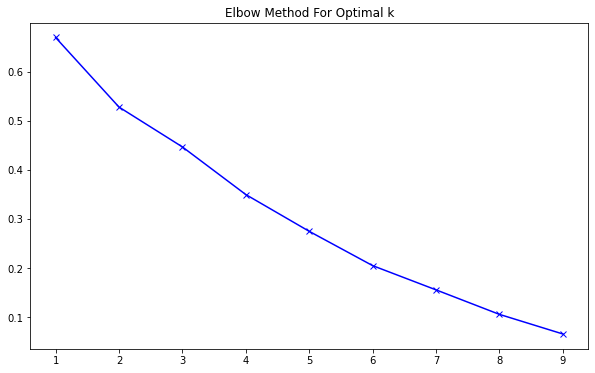

In [218]:
# Elbow method for clustering
bangalore_grouped_clustering = bangalore_grouped.drop('Neighbourhood', 1)
sum_of_squared_distances = []

# maximum of 10 clusters
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(bangalore_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [220]:
# Function for sorting the venues in descencing order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [223]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = bangalore_grouped['Neighbourhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CANTONMENT,Church,Pet Service,Office Building,Gym and Studio,Coffee Shop,Drugstore,Factory,Mexican Restaurant,Retail,Baseball Field
1,DOMLUR,Technology Business,College and University,Nursery School,Lighting Store,Office,Lake,Residential Building,Italian Restaurant,Indian Restaurant,Organic Grocery
2,INDIRANAGAR,Office,Factory,Fuel Station,Bank,Business and Professional Services,Bicycle Store,Convention Center,Housing Development,Coffee Shop,Residential Building
3,MALLESWARAM,Ice Cream Parlor,Advertising Agency,Government Building,Bank,Bus Stop,Liquor Store,Men's Store,Middle School,Fast Food Restaurant,Dessert Shop
4,PETE,Courthouse,Indian Restaurant,Office,Technology Business,Government Building,Karnataka Restaurant,Rajasthani Restaurant,Bus Stop,Retail,Park


In [224]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(bangalore_grouped_clustering)

# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangalore_merged = df_bangalore

# merge madrid_grouped with df_madrid to add latitude/longitude for each neighbourhood
bangalore_merged = bangalore_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

bangalore_merged.head()


,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CANTONMENT,30.60849,-87.32712,0,Church,Pet Service,Office Building,Gym and Studio,Coffee Shop,Drugstore,Factory,Mexican Restaurant,Retail,Baseball Field
1,DOMLUR,12.94329,77.65602,1,Technology Business,College and University,Nursery School,Lighting Store,Office,Lake,Residential Building,Italian Restaurant,Indian Restaurant,Organic Grocery
2,INDIRANAGAR,13.03006,77.49526,3,Office,Factory,Fuel Station,Bank,Business and Professional Services,Bicycle Store,Convention Center,Housing Development,Coffee Shop,Residential Building
3,RAJAJINAGAR,13.00544,77.55693,1,Café,Residential Building,Office,Indian Restaurant,ATM,Temple,Retail,Restaurant,Pub,Fuel Station
4,MALLESWARAM,13.00632,77.56840,4,Ice Cream Parlor,Advertising Agency,Government Building,Bank,Bus Stop,Liquor Store,Men's Store,Middle School,Fast Food Restaurant,Dessert Shop


In [226]:
# Here we examine the cluster 0
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CANTONMENT,Church,Pet Service,Office Building,Gym and Studio,Coffee Shop,Drugstore,Factory,Mexican Restaurant,Retail,Baseball Field


In [227]:
# Here we examine the cluster 1
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,DOMLUR,Technology Business,College and University,Nursery School,Lighting Store,Office,Lake,Residential Building,Italian Restaurant,Indian Restaurant,Organic Grocery
3,RAJAJINAGAR,Café,Residential Building,Office,Indian Restaurant,ATM,Temple,Retail,Restaurant,Pub,Fuel Station
5,PETE,Courthouse,Indian Restaurant,Office,Technology Business,Government Building,Karnataka Restaurant,Rajasthani Restaurant,Bus Stop,Retail,Park
8,SHIVAJINAGAR,Office,Office Building,Residential Building,Indian Restaurant,Platform,Police Station,Car Parts and Accessories,Car Dealership,Print Store,Business and Professional Services


In [228]:
# Here we examine the cluster 2
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 2, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,SADASHIVANAGAR,Spa,Coffee Shop,Indian Restaurant,Health and Beauty Service,Department Store,Bus Station,Gym and Studio,Flower Store,Event Space,Drugstore


In [229]:
# Here we examine the cluster 3
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 3, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,INDIRANAGAR,Office,Factory,Fuel Station,Bank,Business and Professional Services,Bicycle Store,Convention Center,Housing Development,Coffee Shop,Residential Building
9,ULSOOR,Office,Fast Food Restaurant,Adult Store,Department Store,Pizzeria,Stadium,Café,Cemetery,Golf Course,Funeral Home
10,VASANTH NAGAR,Office,Fuel Station,ATM,Business and Professional Services,Spa,Roof Deck,Retail,Restaurant,Indian Restaurant,Hotel


In [230]:
# Here we examine the cluster 4
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 4, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,MALLESWARAM,Ice Cream Parlor,Advertising Agency,Government Building,Bank,Bus Stop,Liquor Store,Men's Store,Middle School,Fast Food Restaurant,Dessert Shop
7,SESHADRIPURAM,Golf Course,Art Gallery,Fast Food Restaurant,Restaurant,Retail,Ice Cream Parlor,Museum,Government Building,College Classroom,Dessert Shop


In [238]:
sales_forecast = pd.DataFrame({'Cluster_code':[0,1,2,3,4],\
                              'Revenue forecast':[1418890,1469947,1961709,1775791,1654978],\
                             'Set up cost':[250000,200000,150000,100000,180000],\
                             'Profitability':[1361971,1575299,1670641,1226979,1129864],\
                             'Store Allocated or not ':[0,1,1,0,0]})
sales_forecast

,Cluster_code,Revenue forecast,Set up cost,Profitability,Store Allocated or not
0,0,1418890,250000,1361971,0
1,1,1469947,200000,1575299,1
2,2,1961709,150000,1670641,1
3,3,1775791,100000,1226979,0
4,4,1654978,180000,1129864,0
